In [21]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
df = pd.read_csv('/home/nick/Downloads/Consistency_expectedIntensity_to_Nick.csv')[['consistency', 'intensity']]
df.head()

,consistency,intensity
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


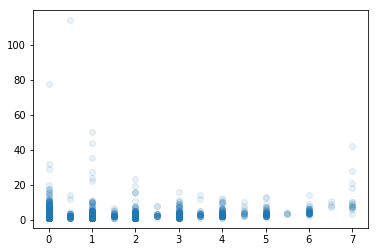

In [23]:
plt.scatter(df.consistency, df.intensity, alpha=.1)

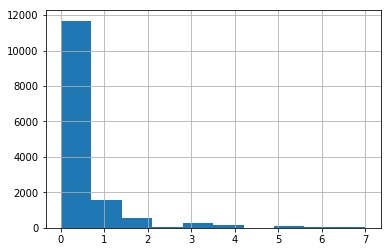

In [24]:
df.consistency.hist()

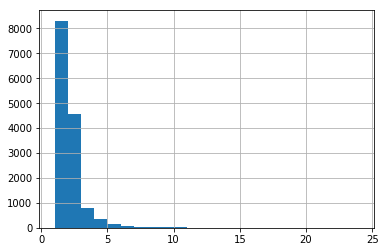

In [25]:
df.intensity.hist(bins=np.arange(1,25))

Look how right skewed these data are. We can try a log transform to get better results

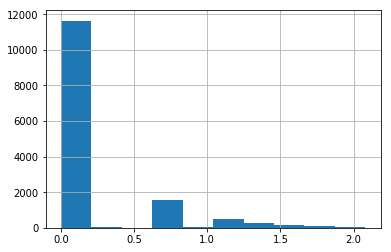

In [26]:
df.consistency.apply(lambda x: np.log(x+1)).hist()

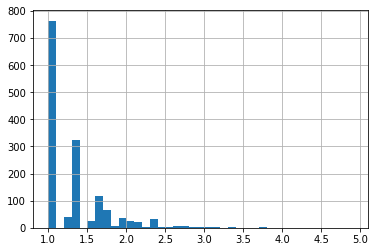

In [27]:
df.intensity.apply(lambda x: np.log(x)).hist(bins=np.arange(1,5,.1))

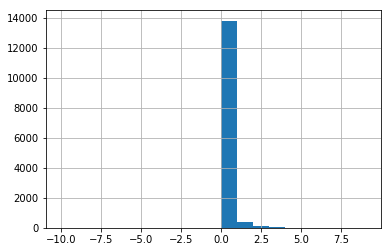

In [28]:
(df.intensity.apply(lambda x: np.log(x)) * df.consistency.apply(lambda x: np.log(x+1))).hist(bins=np.arange(-10,10))

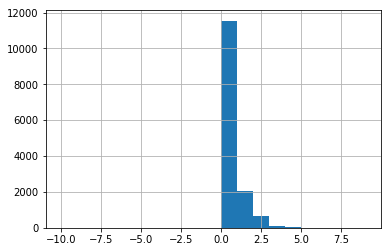

In [29]:
(df.intensity * (df.consistency+1)).apply(np.log).hist(bins=np.arange(-10,10))

In [30]:
df.describe()

,consistency,intensity
count,14376.000000,14376.000000
mean,0.344289,1.697795
std,0.896396,1.877581
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,7.000000,114.000000


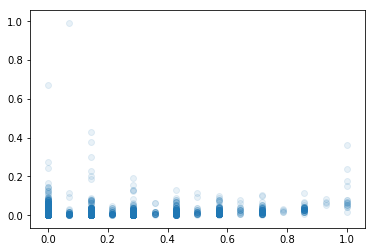

In [31]:
df_scaled = (df-df.min())/df.max()
plt.scatter(df_scaled.consistency, df_scaled.intensity, alpha=.1)

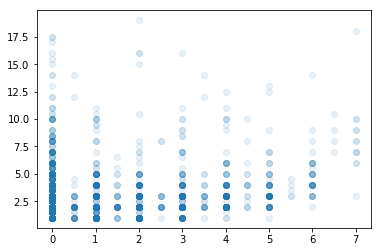

In [32]:
limits = df.apply(lambda x: np.percentile(x, 99.9), axis=0)

df_filtered = df[(df.consistency <= limits.consistency) & (df.intensity <= limits.intensity)]
df_scaled = (df_filtered-df_filtered.min())/df_filtered.max()
plt.scatter(df_filtered.consistency, df_filtered.intensity, alpha=.1)

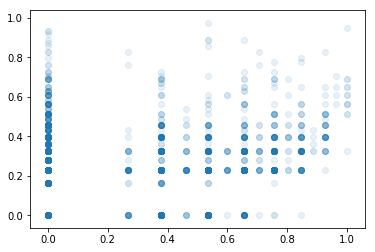

In [33]:
plt.scatter(*df_scaled.apply(np.sqrt).values.T, alpha=.1)

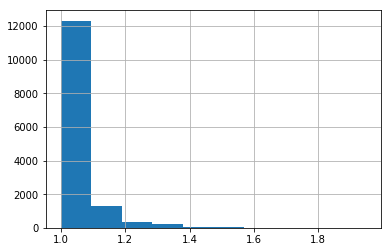

In [34]:
(df_scaled.apply(lambda row: np.sqrt((row.intensity+1)*(row.consistency+1)), axis=1)).hist()

In [35]:
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 3
data = df_scaled.values

def dist(x,y):
    edits_per_week1 = (x[1]+1)*(x[0]+1)
    edits_per_week2 = (y[1]+1)*(y[0]+1)
    return np.abs(edits_per_week1-edits_per_week2)

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=dist, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

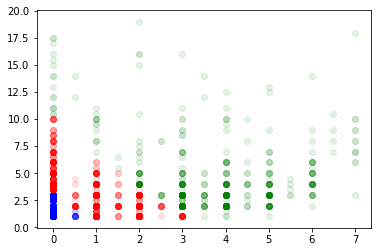

In [36]:
assigned_clusters = np.array(assigned_clusters, dtype=np.int8)
plt.scatter(df_filtered.consistency[assigned_clusters==0], df_filtered.intensity[assigned_clusters==0], alpha=.1, c='b')
plt.scatter(df_filtered.consistency[assigned_clusters==1], df_filtered.intensity[assigned_clusters==1], alpha=.1, c='r')
plt.scatter(df_filtered.consistency[assigned_clusters==2], df_filtered.intensity[assigned_clusters==2], alpha=.1, c='g')

In [37]:
for i in np.unique(assigned_clusters):
    print(np.sum(assigned_clusters == i))

11220
2499
642


In [38]:
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 4
data = df_scaled.apply(np.sqrt).values

def dist(x,y):
    return np.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=dist, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

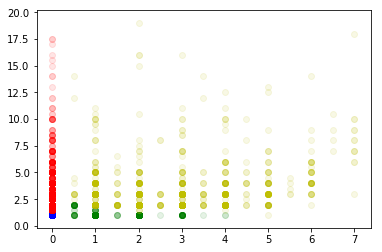

In [39]:
assigned_clusters = np.array(assigned_clusters, dtype=np.int8)
plt.scatter(df_filtered.consistency[assigned_clusters==0], df_filtered.intensity[assigned_clusters==0], alpha=.1, c='b')
plt.scatter(df_filtered.consistency[assigned_clusters==1], df_filtered.intensity[assigned_clusters==1], alpha=.1, c='r')
plt.scatter(df_filtered.consistency[assigned_clusters==2], df_filtered.intensity[assigned_clusters==2], alpha=.1, c='g')
plt.scatter(df_filtered.consistency[assigned_clusters==3], df_filtered.intensity[assigned_clusters==3], alpha=.1, c='y')

In [40]:
for i in np.unique(assigned_clusters):
    print(np.sum(assigned_clusters == i))

7135
4496
1022
1708


In [41]:
maxs = df_filtered.max()
mins = df_filtered.min()
def fs(param):
    def f(x):
        return ((x-mins[param])/maxs[param]) + 1
    def f_inv(x):
        return (x-1)*maxs[param] + mins[param]
    return f, f_inv

fx, fx_inv = fs('consistency')
fy, fy_inv = fs('intensity')

In [42]:
limits

consistency     7.000
intensity      19.625
dtype: float64

In [43]:
df.shape[0] - df_filtered.shape[0]

15

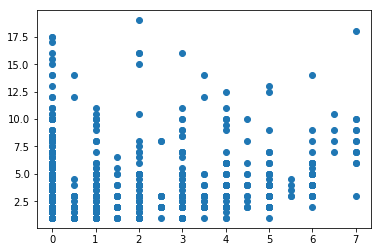

In [44]:
plt.scatter(df_filtered.consistency, df_filtered.intensity)

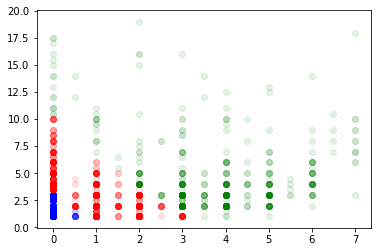

In [45]:
# drop the top 0.1% of outliers
limits = df.apply(lambda x: np.percentile(x, 99.9), axis=0)
df_filtered = df[(df.consistency <= limits.consistency) & (df.intensity <= limits.intensity)]

# normalise the data
df_scaled = (df_filtered-df_filtered.min())/df_filtered.max()

# run K-Means with custom distance metric
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 3
data = df_filtered.values

def dist(x,y):
    # we add one here to stop influence of multiplying by 0
    edits_per_week1 = fx(x[0])*fy(x[1])
    edits_per_week2 = fx(y[0])*fy(y[1])
    # actual distance
    return np.abs(edits_per_week1-edits_per_week2)

# K-means with a number of random restarts
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=dist, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

# Plot the data
assigned_clusters = np.array(assigned_clusters, dtype=np.int8)
plt.scatter(df_filtered.consistency[assigned_clusters==0], df_filtered.intensity[assigned_clusters==0], alpha=.1, c='b')
plt.scatter(df_filtered.consistency[assigned_clusters==1], df_filtered.intensity[assigned_clusters==1], alpha=.1, c='r')
plt.scatter(df_filtered.consistency[assigned_clusters==2], df_filtered.intensity[assigned_clusters==2], alpha=.1, c='g')

# Group sizes
# 11220
# 2499
# 642

0.9755685142507478
8.083467579294018


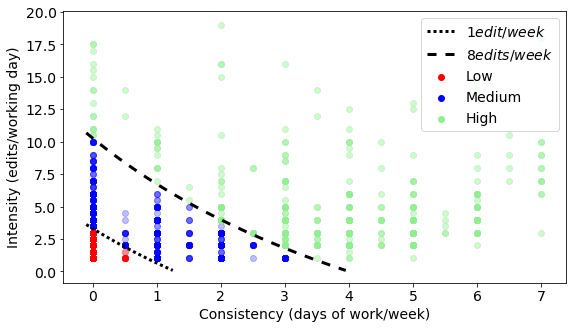

In [46]:
matplotlib.rcParams.update({'font.size': 14})

plt.figure(figsize=(9,5))


l = 0
# draw the first boundary
K = (fx(kclusterer.means()[l][0])*fy(kclusterer.means()[l][1]) + fx(kclusterer.means()[l+1][0])*fy(kclusterer.means()[l+1][1]))/2=
x = np.arange(-1,7.5,0.05)
y = fy_inv(K/fx(x))
x = x[y > 0]
y = y[y > 0]
y = y[x >= -.1]
x = x[x >= -.1]
print(np.max(y*x))

# plot the first boundary
plt.plot(x,y, lw=3, c='black', ls=(0, (1, 1)), label='$1 edit/week$' )

l = 1
# draw the second boundary
K = (fx(kclusterer.means()[l][0])*fy(kclusterer.means()[l][1]) + fx(kclusterer.means()[l+1][0])*fy(kclusterer.means()[l+1][1]))/2
x = np.arange(-1,7.5,0.05)
y = fy_inv(K/fx(x))
x = x[y > 0]
y = y[y > 0]
y = y[x >= -.1]
x = x[x >= -.1]
print(np.max(y*x))

# plot the second boundary
plt.plot(x,y, lw=3, c='black', ls=(0, (3, 3)), label='$8 edits/week$' )


# plot the rest
plt.scatter(df_filtered.consistency[assigned_clusters==0], df_filtered.intensity[assigned_clusters==0], alpha=.25,
            c='red', label='Low')
plt.scatter(df_filtered.consistency[assigned_clusters==1], df_filtered.intensity[assigned_clusters==1], alpha=.25,
            c='blue', label='Medium')
plt.scatter(df_filtered.consistency[assigned_clusters==2], df_filtered.intensity[assigned_clusters==2], alpha=.4,
            c='lightgreen', label='High')

# set the legend to what we want
leg = plt.legend(loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.xlabel('Consistency (days of work/week)')
plt.ylabel('Intensity (edits/working day)')
plt.show()

In [65]:
[v*w for v,w in kclusterer.means()]

[0.0008746913933293257, 2.2963835393934966, 14.499063479827415]

In [39]:
kclusterer.means()

[array([8.91265597e-05, 2.11581762e-02]),
 array([0.1492597 , 0.06304627]),
 array([0.51223854, 0.1601902 ])]

In [62]:
for i in np.unique(assigned_clusters):
    print(np.sum(assigned_clusters == i))

11220
2499
642


No handles with labels found to put in legend.


                  Count
Name                   
Copy Editor     4529509
Strunk & White  2335539
Editor          1685790
8550838


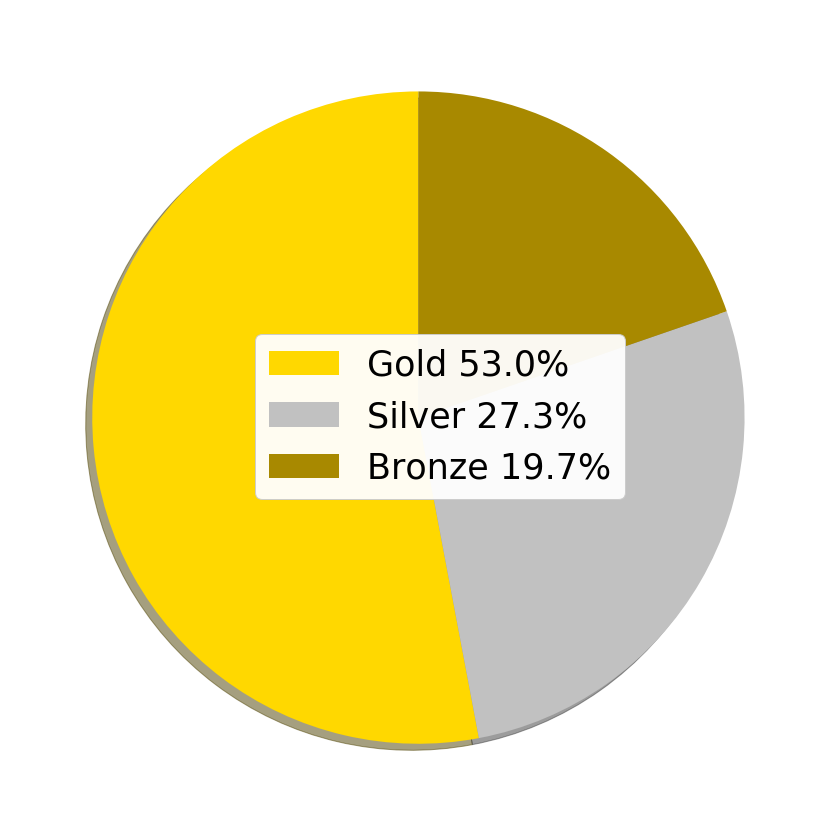

In [85]:
df = pd.read_csv('/home/nick/Downloads/QueryResults (5).csv')
df.rename(columns={'Unnamed: 0': 'Count'}, inplace=True)
df.set_index('Name', inplace=True)

df.loc['Strunk & White', 'Count'] -= df.loc['Copy Editor', 'Count']
df.loc['Editor', 'Count'] -= (df.loc['Copy Editor', 'Count'] + df.loc['Strunk & White', 'Count'])

df.sort_values('Count', inplace=True, ascending=False)
# df.loc['Other','Count'] = 113844098 - df.Count.sum()
print(df)
print(df.Count.sum())

fig, ax = plt.subplots(1,1, figsize=(15,15))

df.reset_index(inplace=True)
ax.pie(df.Count, colors=['#ffd800', '#c1c1c1', '#a88900'], shadow=True, startangle=90)

ax.legend(loc=(1,.4), prop={'size': 15})
ax.set_xticklabels([])

legend = ax.legend(loc=(.3,.4), labels=[f'{x} {np.round(y/sum(df.Count)*100,1)}%' for x,y in zip(['Gold', 'Silver', 'Bronze'], df.Count)], 
           prop={'size': 35})
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_alpha(.95)

plt.show()

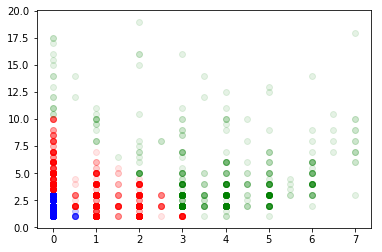

In [15]:
df = pd.read_csv('/home/nick/Downloads/Consistency_expectedIntensity_to_Nick.csv')[['consistency', 'intensity']]

# drop the top 0.1% of outliers
limits = df.apply(lambda x: np.percentile(x, 99.9), axis=0)
df_filtered = df[(df.consistency <= limits.consistency) & (df.intensity <= limits.intensity)]

# normalise the data
df_scaled = (df_filtered-df_filtered.min())/df_filtered.max()

# run K-Means with custom distance metric
from nltk.cluster.kmeans import KMeansClusterer
NUM_CLUSTERS = 3
data = df_scaled.values

def dist(x,y):
    # we add one here to stop influence of multiplying by 0
    edits_per_week1 = (np.e**(x[1] + x[0]))
    edits_per_week2 = (np.e**(y[1] + y[0]))
    # actual distance
    return np.abs(edits_per_week1-edits_per_week2)

# K-means with a number of random restarts
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=dist, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)

# Plot the data
assigned_clusters = np.array(assigned_clusters, dtype=np.int8)
plt.scatter(df_filtered.consistency[assigned_clusters==0], df_filtered.intensity[assigned_clusters==0], alpha=.1, c='b')
plt.scatter(df_filtered.consistency[assigned_clusters==1], df_filtered.intensity[assigned_clusters==1], alpha=.1, c='r')
plt.scatter(df_filtered.consistency[assigned_clusters==2], df_filtered.intensity[assigned_clusters==2], alpha=.1, c='g')

# Group sizes
# 11220
# 2499
# 642

In [16]:
for i in np.unique(assigned_clusters):
    print(np.sum(assigned_clusters == i))

11220
2529
612


(array([1.3674e+04, 5.3600e+02, 6.9000e+01, 4.6000e+01, 1.5000e+01,
        4.0000e+00, 7.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([1.        , 1.15789141, 1.31578282, 1.47367423, 1.63156564,
        1.78945705, 1.94734846, 2.10523987, 2.26313128, 2.4210227 ,
        2.57891411]),
 <a list of 10 Patch objects>)

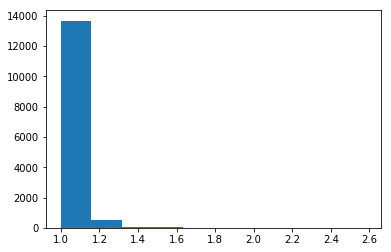

In [19]:
plt.hist(np.e**data[:,1])

In [ ]:
a = np.arange(0,1,.01)
b = np.arange(0,1,.01)



In [2]:
df = pd.read_csv('/home/nick/Downloads/userId_days_counts.csv').drop(columns='Unnamed: 0')
df.head()

,UserId,days,counts
0,1,-7,6
1,1,-6,15
2,1,-5,34
3,1,-4,20
4,1,-3,19


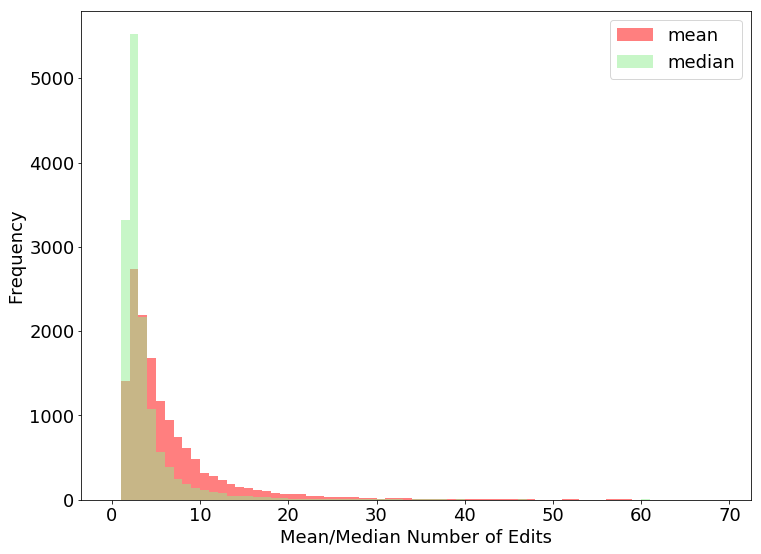

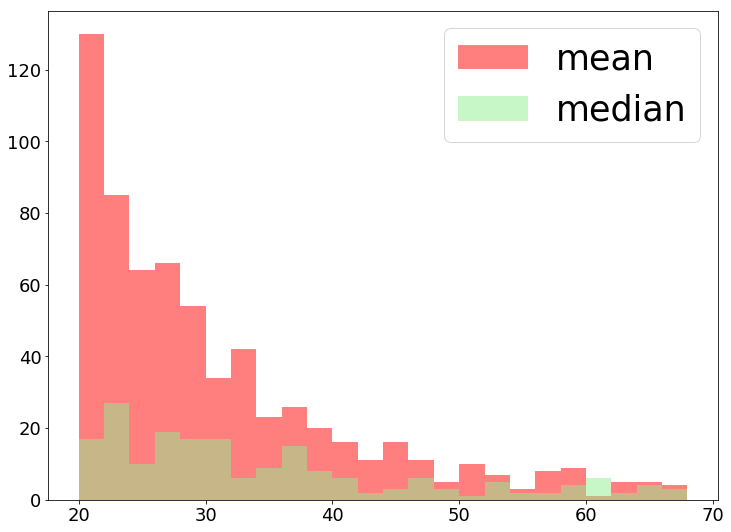

In [18]:
plt.figure(figsize=(12,9))
matplotlib.rcParams.update({'font.size': 18})

cnts = df.groupby('UserId').agg(['mean', 'median']).counts
plt.hist(cnts['mean'], label='mean', bins=np.arange(0,70,1), alpha=.5, color='red')
plt.hist(cnts['median'], label='median', bins=np.arange(0,70,1), alpha=.5, color='lightgreen')
plt.legend(loc='best')
plt.xlabel('Mean/Median Number of Edits')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12,9))
plt.hist(cnts['mean'][cnts['mean']>20], label='mean', bins=np.arange(20,70,2), alpha=.5, color='red')
plt.hist(cnts['median'][cnts['median']>20], label='median', bins=np.arange(20,70,2), alpha=.5, color='lightgreen')
plt.legend(loc='best',prop={'size': 35})
plt.show()

In [ ]:
sns.boxplot(data=df, x='UserId', y='counts')

KeyboardInterrupt: 